In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class RNN(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.rnn = nn.RNN(dim_input, dim_hidden, 1, nonlinearity='relu')
        self.W = nn.Linear(dim_hidden, dim_output)

    def forward(self, x):
        h_all, h_final = self.rnn(x)
        return self.W(h_final.squeeze(0))


class GRU(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.gru = nn.GRU(dim_input, dim_hidden, 1)
        self.W = nn.Linear(dim_hidden, dim_output)

    def forward(self, x):
        h_all, h_final = self.gru(x)
        return self.W(h_final.squeeze(0))


class LSTM(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.lstm = nn.LSTM(dim_input, dim_hidden, 1)
        self.W = nn.Linear(dim_hidden, dim_output)

    def forward(self, x):
        h_all, (h_final, c_final) = self.lstm(x)
        return self.W(h_final.squeeze(0))

In [3]:
class RandomSequenceDataset():
    def __init__(self, dimension, sequence_length, batch_size, variance=1.0):
        self.dim = dimension
        self.sl = sequence_length
        self.bs = batch_size
        self.var = variance

    def get_batch(self):
        return torch.randn((self.sl, self.bs, self.dim)) * self.var

### TODO: Modify **AttentivePooling** and **AttentionGRU**
1) Implement different types of attention score functions.
2) Implement the ReLU normalisation.

In [18]:
class AttentivePooling(nn.Module):
    # Computes attention with the last hidden state as the key
    # Note: will calculate attention for all elements in the batch in parallel.

    def __init__(self, dim_in):
        super().__init__()
        self.W = nn.Linear(dim_in, dim_in)

    def forward(self, h_all, xin):
        # NOTE: h_all and xin both have the shape: [sequence length, batch size, hidden size]        
        
        
        

        
        # get the last hidden state and compute a key from it 
        h_last = h_all[-1] # h_last is of shape [batch_size, hidden size]
        key_a = self.W(h_last) # key_a is of shape [batch_size, hidden size]

        # calculate the attention vector:
        # permute dimensions in h_all to order: [batch, seq, hidden]
        h_all = torch.permute(h_all, (1, 0, 2)) 

        # batch matrix multiplication of [batch, seq, hidden] x [batch, hidden, 1] = [batch, seq, 1]
        a = torch.matmul(h_all, key_a.unsqueeze(2))

        # remove the trailing dimension of a and then compute the softmax over the sequence dimension
        a = nn.functional.softmax(a.squeeze(2), dim=-1)

        # calculate the context vector using the attention and hidden states
        # [batch, 1, seq] x [batch, seq, hidden] = [batch, 1, hidden]
        output = torch.bmm(a.unsqueeze(1), h_all)

        return output.squeeze(1)

In [5]:
class AttentionGRU(nn.Module):
    # A GRU with attention before a linear classification layer
    # this is an attention GRU for classification, attention is only calculated
    # at the end of the sequence rather than every step which is done in 
    # self-attention or attention auto-regressive models.
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.gru = nn.GRU(dim_input, dim_hidden, 1)
        self.W = nn.Linear(dim_hidden, dim_output)
        self.attention = AttentivePooling(dim_hidden)

    def forward(self, x):
        h_all, h_final = self.gru(x)
        attn_output = self.attention(h_all, x)
        res = self.W(attn_output)
        return res

In [6]:
input_dimension = 4
hidden_dimension = 4
sequence_lengths = [3, 5, 10, 20, 40, 80, 100]

# you can try this but the cpu is recommended for this task
# it is often faster when the models are small like this
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def train_model(model, optimizer, sequence_length, dimension=input_dimension, batch_size=512):
    # random dataset generator
    dataset = RandomSequenceDataset(dimension, sequence_length, batch_size)

    num_epochs = 100
    num_batches = 5  # batches per epoch
    best_loss = 1e10 # stores the best average training loss in any epoch

    for epoch in range(num_epochs):
        average_loss = 0
        for i in range(num_batches):

            # get the training batch and move it to the gpu if one is found
            # shape: [sequence_length x batch_size x dimension]
            x = dataset.get_batch().to(device)

            # the target is the first element in the sequence, shape [batch_size x dimension]
            y = x[0]

            # run the specified type of RNN model and get the output, shape [batch_size x dimension]
            y_h = model(x)

            # calculate loss and update network
            loss = F.mse_loss(y_h, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute average loss for this epoch
            average_loss += loss.item() / num_batches
        if average_loss < best_loss:
            best_loss = average_loss
    return best_loss

In [8]:
def plot_losses(losses, sequence_lengths):
    plt.plot(sequence_lengths, losses, marker='o')
    plt.xlabel('Sequence Length')
    plt.ylabel('MSE')
    plt.ylim([-0.05, None])
    plt.show()

In [9]:
def memory_test(model_func, sequence_lengths):
    # train the model on different length sequences 
    # and record the average training loss
    losses = []
    for sequence_length in sequence_lengths:
        # create a new copy of the model
        model = model_func().to(device)

        # create an optimizer for the model
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        # train the model and store the best average loss
        loss = train_model(model, optimizer, sequence_length=sequence_length)
        print(f'Sequence length: {sequence_length}, \t running average loss: {loss}')
        losses.append(loss)
    
    plot_losses(losses, sequence_lengths)

Sequence length: 3, 	 running average loss: 0.9666483283042908
Sequence length: 5, 	 running average loss: 0.9731792092323304
Sequence length: 10, 	 running average loss: 0.972090768814087
Sequence length: 20, 	 running average loss: 0.9656549334526061
Sequence length: 40, 	 running average loss: 0.9675729751586913
Sequence length: 80, 	 running average loss: 0.9716164827346802
Sequence length: 100, 	 running average loss: 0.9663811802864074


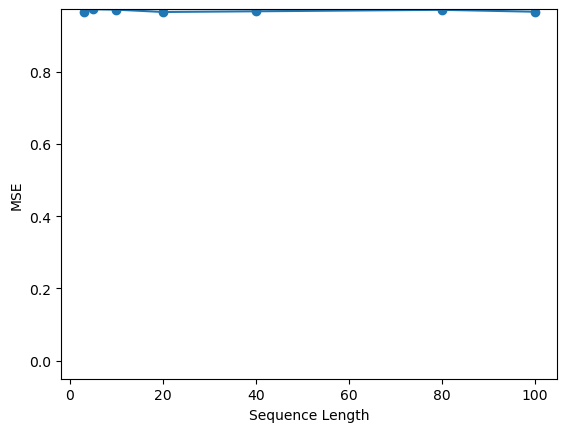

In [10]:
memory_test(lambda: RNN(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

Sequence length: 3, 	 running average loss: 0.0010333795100450516
Sequence length: 5, 	 running average loss: 0.0012728809961117804
Sequence length: 10, 	 running average loss: 0.23504858613014223
Sequence length: 20, 	 running average loss: 0.23527448177337643
Sequence length: 40, 	 running average loss: 0.7268030285835267
Sequence length: 80, 	 running average loss: 0.47710393667221074
Sequence length: 100, 	 running average loss: 0.7438917398452758


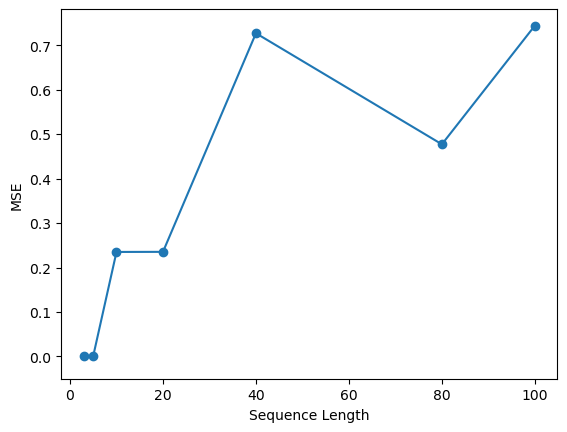

In [11]:
memory_test(lambda: GRU(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

Sequence length: 3, 	 running average loss: 0.10045815706253051
Sequence length: 5, 	 running average loss: 0.006231823842972517
Sequence length: 10, 	 running average loss: 0.9591719269752502
Sequence length: 20, 	 running average loss: 0.9702855467796326
Sequence length: 40, 	 running average loss: 0.9646853446960449
Sequence length: 80, 	 running average loss: 0.9702906489372254
Sequence length: 100, 	 running average loss: 0.9567080974578858


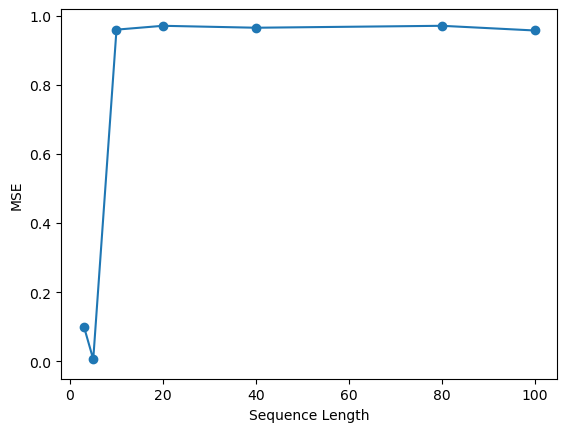

In [12]:
memory_test(lambda: LSTM(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

Sequence length: 3, 	 running average loss: 0.001324890530668199
Sequence length: 5, 	 running average loss: 0.0009798252605833114
Sequence length: 10, 	 running average loss: 0.0013369434978812932
Sequence length: 20, 	 running average loss: 0.0009171884623356164
Sequence length: 40, 	 running average loss: 0.0014322307892143727
Sequence length: 80, 	 running average loss: 0.0019151930464431643
Sequence length: 100, 	 running average loss: 0.00105034071020782


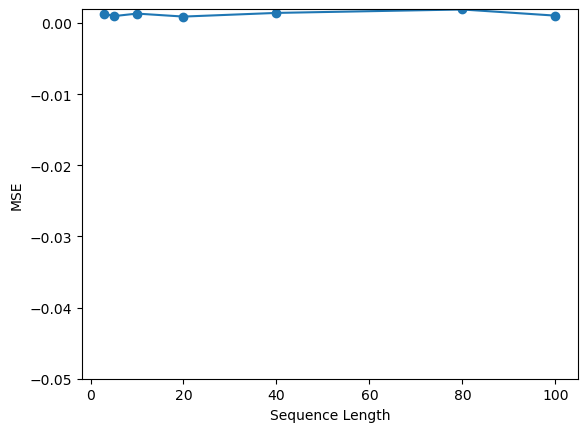

In [17]:
memory_test(lambda: AttentionGRU(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

Sequence length: 3, 	 running average loss: 0.0008153095142915845
Sequence length: 5, 	 running average loss: 0.004099126486107707
Sequence length: 10, 	 running average loss: 0.001613238989375532
Sequence length: 20, 	 running average loss: 0.000897389033343643
Sequence length: 40, 	 running average loss: 0.0014447689289227128
Sequence length: 80, 	 running average loss: 0.0010204409947618843
Sequence length: 100, 	 running average loss: 0.0011190272867679597


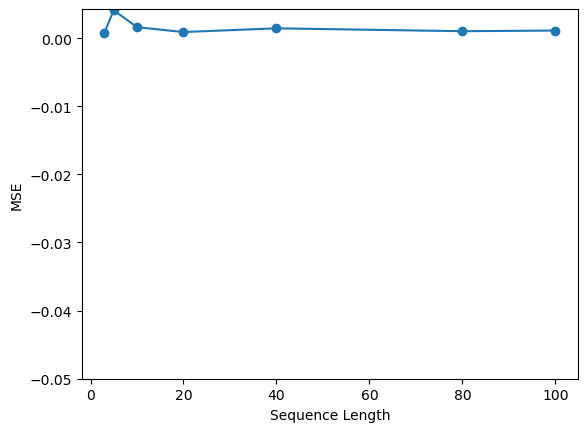

In [15]:
memory_test(lambda: AttentionGRU(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

In [20]:
memory_test(lambda: AttentionGRU(input_dimension, hidden_dimension, input_dimension), sequence_lengths)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x1 and 4x4)